<a href="https://colab.research.google.com/github/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/blob/develop/Thermomut_10_27_Louis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!pip install pandas
!pip install sentence_transformers
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
!mkdir -p ~/.kaggle                                          
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
!chmod 600 ~/.kaggle/kaggle.json                            
!kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
!kaggle competitions download -c novozymes-enzyme-stability-prediction         
!unzip -o *.zip >> log

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
- competition is now set to: novozymes-enzyme-stability-prediction
novozymes-enzyme-stability-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
SEED = 42
import os
import random as rn
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

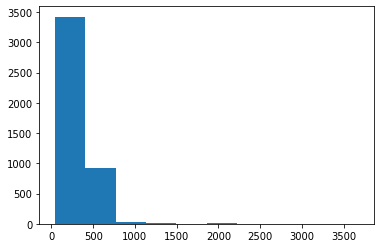

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/main/MutationsDeltaTM.csv')
df.insert(0,"sequence_len", df.wt_sequence.apply(lambda x: len(x)))

plt.hist(df.sequence_len.values)
plt.show()


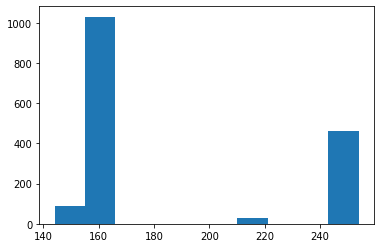

,sequence_len,Unnamed: 0,mutated_sequence,pdb_id,wt_sequence,mutations,delta_tm,n
0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.3,727
1,164,1,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.2,727
2,164,2,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.6,727
3,164,3,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,0.6,727
4,164,4,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,1.0,727
...,...,...,...,...,...,...,...,...
4405,212,758,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,M165D,4.2,29
4406,212,759,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,G186S,2.4,29
4407,212,760,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,Y192N,3.0,29
4408,212,761,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,N205T,1.4,29


In [17]:
df = df.drop(df[df.sequence_len > 256].index)
df = df.drop(df[df.sequence_len < 128].index)

df['n'] = df.groupby('wt_sequence').wt_sequence.transform('count')
df = df.loc[df.n>20]

plt.hist(df.sequence_len.values)
plt.show()

df

In [18]:
df = df.drop(df[df.pdb_id == '-'].index)
df = df.drop(df[df.pdb_id == '1.00E+21'].index)

df = df.sample(frac=1, axis=1).reset_index(drop=True)

pdb_ids = np.unique(df.pdb_id.values)
pdb_ids

for pdb_id in pdb_ids:
  row_indices = df[df.pdb_id == pdb_id].index
  delta_tms = list(np.sort([df.iloc[row_index].delta_tm for row_index in row_indices]))
  indices = []
  for row_index in row_indices:
    ind = delta_tms.index(df.iloc[row_index].delta_tm)
    indices.append(ind)
  indices = np.asarray(indices) / float(len(indices))
  # Rank ordering... not sure it helps
  #df.at[row_indices, 'delta_tm'] = indices
  #delta_tms = [df.iloc[row_index].delta_tm for row_index in row_indices]
  #print(indices)

df

,Unnamed: 0,mutations,sequence_len,n,mutated_sequence,wt_sequence,pdb_id,delta_tm
0,0,W138Y,164,727,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,-6.3
1,1,"W138Y,W126Y,W158Y",164,727,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,-6.2
2,2,"W138Y,W126Y,W158Y",164,727,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,-6.6
3,3,E128A,164,727,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,0.6
4,4,V131A,164,727,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,1.0
...,...,...,...,...,...,...,...,...
1603,758,M165D,212,29,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,4.2
1604,759,G186S,212,29,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,2.4
1605,760,Y192N,212,29,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,3.0
1606,761,N205T,212,29,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,1.4


In [19]:
# From: https://colab.research.google.com/drive/1TUj-ayG3WO52n5N50S7KH9vtt6zRkdmj?usp=sharing#scrollTo=c5XqIyeNStZP
import torch

!mkdir protT5 # root directory for storing checkpoints, results etc
!mkdir protT5/protT5_checkpoint # directory holding the ProtT5 checkpoint
!mkdir protT5/sec_struct_checkpoint # directory storing the supervised classifier's checkpoint
!mkdir protT5/output # directory for storing your embeddings & predictions
!wget -nc -P protT5/ https://rostlab.org/~deepppi/example_seqs.fasta
# Huge kudos to the bio_embeddings team here! We will integrate the new encoder, half-prec ProtT5 checkpoint soon
!wget -nc -P protT5/sec_struct_checkpoint http://data.bioembeddings.com/public/embeddings/feature_models/t5/secstruct_checkpoint.pt

# Network architecture for secondary structure prediction. 
# Convolutional neural network (two convolutional layers) to predict secondary structure
class ConvNet( torch.nn.Module ):
    def __init__( self ):
        super(ConvNet, self).__init__()
        # This is only called "elmo_feature_extractor" for historic reason
        # CNN weights are trained on ProtT5 embeddings
        self.elmo_feature_extractor = torch.nn.Sequential(
                        torch.nn.Conv2d( 1024, 32, kernel_size=(7,1), padding=(3,0) ), # 7x32
                        torch.nn.ReLU(),
                        torch.nn.Dropout( 0.25 ),
                        )
        n_final_in = 32
        self.dssp3_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d( n_final_in, 3, kernel_size=(7,1), padding=(3,0)) # 7
                        )
        
        self.dssp8_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d( n_final_in, 8, kernel_size=(7,1), padding=(3,0))
                        )
        self.diso_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d( n_final_in, 2, kernel_size=(7,1), padding=(3,0))
                        )
        
    def forward( self, x):
        # IN: X = (B x L x F); OUT: (B x F x L, 1)
        x = x.permute(0,2,1).unsqueeze(dim=-1) 
        x         = self.elmo_feature_extractor(x) # OUT: (B x 32 x L x 1)
        d3_Yhat   = self.dssp3_classifier( x ).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 3)
        d8_Yhat   = self.dssp8_classifier( x ).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 8)
        diso_Yhat = self.diso_classifier(  x ).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 2)
        return d3_Yhat, d8_Yhat, diso_Yhat

def load_sec_struct_model():
  checkpoint_dir="./protT5/sec_struct_checkpoint/secstruct_checkpoint.pt"
  state = torch.load( checkpoint_dir )
  model = ConvNet()
  model.load_state_dict(state['state_dict'])
  model = model.eval()
  model = model.to('cuda')
  print('Loaded sec. struct. model from epoch: {:.1f}'.format(state['epoch']))

  return model

sec_struct_model = load_sec_struct_model()

mkdir: cannot create directory ‘protT5’: File exists
mkdir: cannot create directory ‘protT5/protT5_checkpoint’: File exists
mkdir: cannot create directory ‘protT5/sec_struct_checkpoint’: File exists
mkdir: cannot create directory ‘protT5/output’: File exists
File ‘protT5/example_seqs.fasta’ already there; not retrieving.

File ‘protT5/sec_struct_checkpoint/secstruct_checkpoint.pt’ already there; not retrieving.

Loaded sec. struct. model from epoch: 18.0


In [20]:
from transformers import T5Tokenizer, T5EncoderModel
import re
import torch

#import torch_xla
#import torch_xla.core.xla_model as xm

def get_embeddings(X, batch_size=32):

  tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
  model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)
  model = model.to('cuda')

  sequences = [re.sub(r"[UZOB]", "X", ' '.join(list(x))) for x in X]
  num_sequences = len(sequences)

  dataloader = torch.utils.data.DataLoader(sequences, batch_size=batch_size)

  embedding_size = 1024
  truncate_size = 256

  sequence_embeddings = np.empty(shape=[0,embedding_size])
  structure_embeddings = np.empty(shape=[0,truncate_size])

  with torch.no_grad():
    i = 0
    for batch in dataloader:

      if i % 10 == 0:
        print('Batch %i' % i)
      
      tokenized = tokenizer.batch_encode_plus(
        batch, 
        add_special_tokens=True, 
        padding="longest"
      )

      outputs = model(
        input_ids = torch.tensor(tokenized['input_ids']).to('cuda'),
        attention_mask = torch.tensor(tokenized['attention_mask']).to('cuda')
      )

      # last_hidden_state -> ( batch-size x max_seq_len_in_minibatch x embedding_dim )

      # iterate on each protein in batch
      for j in range(0, outputs.last_hidden_state.shape[0]):
        
        # average pooling to get per-protein embeddings (1024-d)
        average_pooled = outputs.last_hidden_state[j,0:truncate_size,:].mean(dim=0)
        encoded = average_pooled.detach().cpu().numpy()
        sequence_embeddings = np.concatenate([sequence_embeddings, encoded.reshape(1,-1)])

        # predict secondary structure
        d3_Yhat, d8_Yhat, diso_Yhat = sec_struct_model(outputs.last_hidden_state.float())
        encoded_structure = np.zeros((truncate_size)) - 1
        # 3-state secondary structure
        # https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2280-5
        sec_encoded = torch.max(d3_Yhat[j,0:truncate_size], dim=1)[1].detach().cpu().numpy()
        encoded_structure[0:len(sec_encoded)] = sec_encoded
        structure_embeddings = np.concatenate([structure_embeddings, encoded_structure.reshape(1,-1)])

      i += 1

  return [sequence_embeddings.reshape((num_sequences,embedding_size)),
          structure_embeddings.reshape((num_sequences,truncate_size))]

test = get_embeddings(np.asarray([df.wt_sequence.values[0]]))

print(test)

Batch 0
[array([[ 0.03533936, -0.02758789,  0.06188965, ..., -0.0458374 ,
        -0.05252075, -0.00994873]]), array([[ 2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
         2.,  2.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,
         1.,  1.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
         2.,  2.,  2.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         2., 

In [21]:
wt_sequence_embeddings, wt_structure_embeddings = get_embeddings(df.wt_sequence.values)
mutated_sequence_embeddings, mutated_structure_embeddings = get_embeddings(df.mutated_sequence.values)

Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50


In [22]:
def get_masks(df_ex):
  truncate_size = 256
  
  sequence_masks = np.empty(shape=[0,truncate_size])
  mutation_masks = np.empty(shape=[0,truncate_size])

  for i, row in df_ex.iterrows():
    sequence_mask = np.zeros((truncate_size))
    sequence_mask[0:len(row['wt_sequence'])] = 1

    matches = re.search('([A-Z])([0-9]+)([A-Z])', row['mutations'])
    if matches is None:
      print(row['mutations'])
    mutation_mask = np.zeros((truncate_size))
    mutation_mask[int(matches[2])] = 1

    sequence_masks = np.concatenate([sequence_masks, sequence_mask.reshape(1,-1)])
    mutation_masks = np.concatenate([mutation_masks, mutation_mask.reshape(1,-1)])

  return [sequence_masks, mutation_masks]


In [23]:
sequence_attention_masks, mutation_attention_masks = get_masks(df)

In [24]:
from sklearn.model_selection import train_test_split

X = np.hstack([
    wt_sequence_embeddings, 
    mutated_sequence_embeddings, 
    wt_sequence_embeddings-mutated_sequence_embeddings,
    wt_structure_embeddings, 
    mutated_structure_embeddings, 
    wt_structure_embeddings-mutated_structure_embeddings,
    sequence_attention_masks, 
    mutation_attention_masks,
    #sequence_attention_masks-mutation_attention_masks
])
y = df.delta_tm.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=SEED)

In [25]:
df_pretrain = pd.read_csv('https://raw.githubusercontent.com/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/main/MutationsDeltaDGPredictedTm.csv')
df_pretrain.insert(0,"sequence_len", df_pretrain.wt_sequence.apply(lambda x: len(x)))

df_pretrain = df_pretrain.drop(df_pretrain[df_pretrain.sequence_len > 256].index)
df_pretrain = df_pretrain.drop(df_pretrain[df_pretrain.sequence_len < 128].index)

df_pretrain['n'] = df_pretrain.groupby('wt_sequence').wt_sequence.transform('count')
df_pretrain = df_pretrain.loc[df_pretrain.n>20]

df_pretrain

,sequence_len,Unnamed: 0,delta_tm,mutated_sequence,pdb_id,wt_sequence,mutations,n
2,164,2,-5.34727,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,398
3,164,3,-5.49356,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",398
16,164,17,-0.78797,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,398
17,164,18,-0.51978,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,398
18,164,19,-11.39382,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,L133A,398
...,...,...,...,...,...,...,...,...
5267,231,13413,16.13263,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,1STN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,V181E,566
5268,231,13415,17.35169,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,1STN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,I174E,566
5276,155,13527,-1.17807,MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTV...,2AFG,MAEGEITTFTALTEKFNLPPGNYKKPKLLYCSNGGHFLRILPDGTV...,F100W,32
5278,154,13551,0.04099,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSQPETLEKFDR...,1BVC,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,H37Q,37


In [26]:
pretrain_sequence_attention_masks, pretrain_mutation_attention_masks = get_masks(df_pretrain)

pretrain_wt_sequence_embeddings, pretrain_wt_structure_embeddings = get_embeddings(df_pretrain.wt_sequence.values)
pretrain_mutated_sequence_embeddings, pretrain_mutated_structure_embeddings = get_embeddings(df_pretrain.mutated_sequence.values)


Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50


In [27]:
X_pretrain = np.hstack([
    pretrain_wt_sequence_embeddings, 
    pretrain_mutated_sequence_embeddings, 
    pretrain_wt_sequence_embeddings-pretrain_mutated_sequence_embeddings,
    pretrain_wt_structure_embeddings, 
    pretrain_mutated_structure_embeddings, 
    pretrain_wt_structure_embeddings-pretrain_mutated_structure_embeddings,
    pretrain_sequence_attention_masks, 
    pretrain_mutation_attention_masks,
    #pretrain_sequence_attention_masks-pretrain_mutation_attention_masks
])
y_pretrain = df_pretrain.delta_tm.values

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4352)              0         
                                                                 
 dense (Dense)               (None, 1024)              4457472   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

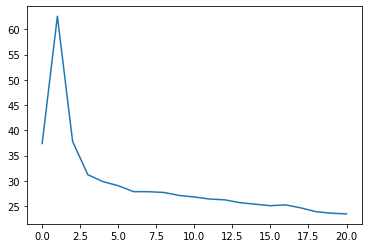

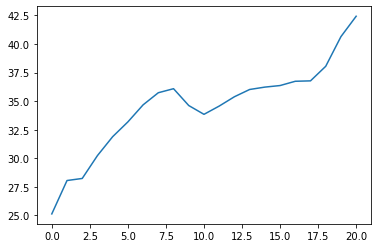

Epoch 1/1000
1/1 [==============================] - 0s 118ms/step - loss: 60.9611 - mse: 60.7335 - val_loss: 34.7813 - val_mse: 34.5573
Epoch 2/1000
1/1 [==============================] - 0s 63ms/step - loss: 37.3107 - mse: 37.0832 - val_loss: 33.1668 - val_mse: 32.9427
Epoch 3/1000
1/1 [==============================] - 0s 61ms/step - loss: 35.3550 - mse: 35.1273 - val_loss: 31.8219 - val_mse: 31.5976
Epoch 4/1000
1/1 [==============================] - 0s 62ms/step - loss: 30.6319 - mse: 30.4040 - val_loss: 30.9221 - val_mse: 30.6975
Epoch 5/1000
1/1 [==============================] - 0s 62ms/step - loss: 30.6724 - mse: 30.4444 - val_loss: 30.2575 - val_mse: 30.0326
Epoch 6/1000
1/1 [==============================] - 0s 64ms/step - loss: 29.4212 - mse: 29.1931 - val_loss: 29.6645 - val_mse: 29.4393
Epoch 7/1000
1/1 [==============================] - 0s 64ms/step - loss: 29.5619 - mse: 29.3337 - val_loss: 29.2367 - val_mse: 29.0110
Epoch 8/1000
1/1 [==============================] - 0s

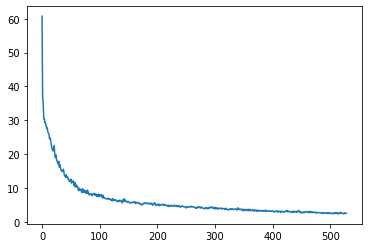

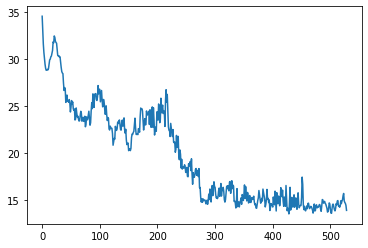

In [28]:
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
import tensorflow.keras as keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

GlorotInit = keras.initializers.GlorotNormal(seed=SEED)

m = keras.models.Sequential([
    Flatten(input_shape=[X.shape[1]]),
    Dense(1024, activation="relu", kernel_initializer=GlorotInit),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation="relu", kernel_initializer=GlorotInit),
    BatchNormalization(),
    Dropout(0.15),
    Dense(1024, activation="relu", kernel_initializer=GlorotInit,
      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.L2(1e-4),
      activity_regularizer=regularizers.L2(1e-5)
    ),
    BatchNormalization(),
    Dropout(0.10),
    Dense(1, kernel_initializer=GlorotInit)
])

m.summary()

initial_learning_rate = 0.001
decay_steps = 1000

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn, clipvalue=1.0)
m.compile(loss="mse", optimizer=optimizer, metrics=['mse'])

callback_pretraining = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

# pretrain
hist = m.fit(X_pretrain, y_pretrain, 
             batch_size=2048, 
             epochs=1000, 
             validation_split=0.3, 
             callbacks=[callback_pretraining], 
             #verbose=False
)

plt.plot(hist.history['mse'])
plt.show()

plt.plot(hist.history['val_mse'])
plt.show()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=100,
    min_delta=0.0001,
    restore_best_weights=True,
)

# train
hist = m.fit(X_train, y_train, 
             batch_size=2048, 
             epochs=1000, 
             validation_split=0.3, 
             callbacks=[callback], 
             #verbose=False
)

plt.plot(hist.history['mse'])
plt.show()

plt.plot(hist.history['val_mse'])
plt.show()

In [29]:
from scipy.stats import spearmanr

y_pred = m.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
corr = spearmanr(y_pred, y_test)

print('MSE: %f' % mse)
print('Corr: %f' % corr[0])

#MSE: 19.334102
#Corr: 0.751555

17/17 [==============================] - 0s 2ms/step
MSE: 19.334102
Corr: 0.751555


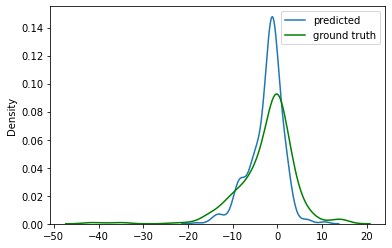

In [42]:
import seaborn as sns

sns.kdeplot(data=y_pred, color='blue', label='predicted')
sns.kdeplot(data=y_test, color='green', label='ground truth')
plt.legend()
plt.show()

In [31]:
df_test = pd.read_csv('test.csv', low_memory=False); df_test

def get_test_masks(sequences, wt):
  truncate_size = 256
  
  sequence_masks = np.empty(shape=[0,truncate_size])
  mutation_masks = np.empty(shape=[0,truncate_size])

  for seq in sequences:
    sequence_mask = np.zeros((truncate_size))
    sequence_mask[0:len(wt)] = 1

    mutation_index = next((i for i, (char1, char2) in enumerate(zip(wt, seq)) if char1 != char2), None)
    mutation_mask = np.zeros((truncate_size))
    mutation_mask[mutation_index] = 1

    sequence_masks = np.concatenate([sequence_masks, sequence_mask.reshape(1,-1)])
    mutation_masks = np.concatenate([mutation_masks, mutation_mask.reshape(1,-1)])

  return [sequence_masks, mutation_masks]

wt = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
wt_embeddings = get_embeddings(np.asarray([wt]))
wt_sequence_embedding = wt_embeddings[0][0]
wt_structure_embedding = wt_embeddings[1][0]

test_wt_sequence_embeddings = np.asarray([wt_sequence_embedding for x in range(0, len(df_test.protein_sequence.values))])
test_wt_structure_embeddings = np.asarray([wt_structure_embedding for x in range(0, len(df_test.protein_sequence.values))])

test_sequence_attention_masks, test_mutation_attention_masks = get_test_masks(df_test.protein_sequence.values,wt)
test_mutated_sequence_embeddings, test_mutated_structure_embeddings = get_embeddings(df_test.protein_sequence.values)

test_embeddings = np.hstack([
    test_wt_sequence_embeddings, 
    test_mutated_sequence_embeddings, 
    test_wt_sequence_embeddings-test_mutated_sequence_embeddings,
    test_wt_structure_embeddings, 
    test_mutated_structure_embeddings, 
    test_wt_structure_embeddings-test_mutated_structure_embeddings,
    test_sequence_attention_masks, 
    test_mutation_attention_masks
  ])

Batch 0
Batch 0
Batch 10
Batch 20
Batch 30
Batch 40
Batch 50
Batch 60
Batch 70


76/76 [==============================] - 0s 2ms/step
-5.768155


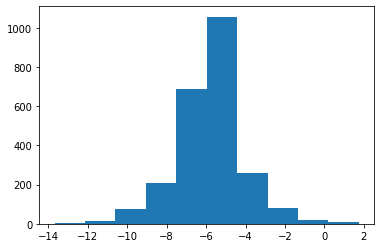

In [32]:
preds = m.predict(test_embeddings)
preds

print(np.mean(preds))

plt.hist(preds)
plt.show()

In [33]:
pY = pd.DataFrame(preds, index=range(31390,len(preds)+31390), columns=['tm'])

ToCSV = lambda df_tmp, fname: df_tmp.round(5).to_csv(f'{fname}.csv', index_label='seq_id')
ToCSV(pY, '/content/gdrive/MyDrive/Kaggle/Novozymes_Submission')